<a href="https://colab.research.google.com/github/gauravsharma99/cnn_from_scratch/blob/main/CNN_from_scratch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CNN

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import os
from tqdm import tqdm
import math
import pickle
import time

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
def train_test_split(X,y,ratio=0.7):
    num_samples=X.shape[0]
    num_train=int(num_samples * ratio)
    indices=np.arange(num_samples)
    np.random.shuffle(indices)
    train_indices = indices[:num_train]
    test_indices = indices[num_train:]
    X_train = X[train_indices]
    y_train=y[train_indices]
    X_test=X[test_indices]
    y_test=y[test_indices]
    return X_train,X_test,y_train,y_test

In [ ]:
class linear:
    def __init__(self, no_of_neurons_prev, no_of_neurons, learning_rate, reg_type = None, reg_param = None):
        self.no_of_neurons = no_of_neurons
        self.no_of_neurons_prev = no_of_neurons_prev
        self.weights = np.random.randn(no_of_neurons, no_of_neurons_prev )
        self.bias = np.random.randn(no_of_neurons)
        self.x = None
        self.lr = learning_rate
        self.grad = None
        self.reg_type = reg_type
        self.reg_param = reg_param

    def forward(self,x):
        self.x = x
        val = np.matmul(self.weights, x.T)
        val = val.T +self.bias
        return val

    def get_grad(self, upward_grad):
        self.grad= upward_grad
        temp = np.matmul(upward_grad, self.weights )
        return temp

    def update_weights(self):
        weight_grads = np.matmul(self.grad.T, self.x) * self.lr

        temp = np.sum(self.grad, axis =0)
        self.bias -= temp * self.lr

        if self.reg_type is not None:
            if self.reg_type == 'L2':
                self.weights -= self.reg_param [1]* self.weights

            elif self.reg_type == 'L1':
                self.weights -=  self.reg_param [0]* np.sign(self.weights)

            elif self.reg_type == 'Elastic':
                temp = self.reg_param[0] * np.sign(self.weights) + self.reg_param[1] * self.weights
                self.weights -= temp

        self.weights -= weight_grads



## Activation Functions

In [ ]:
#Sigmoid Activation Function
class sigmoid:
    def __init__(self):
        pass

    def forward(self, x):
        self.sigmoid_x = 1.0/(1.0 + np.exp(-x))
        return self.sigmoid_x

    def get_grad(self, outward_gradient):
        temp = self.sigmoid_x * (1-self.sigmoid_x)
        return  temp * outward_gradient

#RELU Activation Function
class ReLU:
    def __init__(self):
        pass

    def forward(self, X):
        Y = np.zeros(X.shape)
        Y[X>0] = X[X>0]
        self.relu_x = Y
        return Y

    def get_grad(self, outward_gradient):
        temp = self.relu_x
        temp[temp > 0] = 1
        return temp * outward_gradient

#Tanh Activation Function
class Tanh():
    def __init__(self):
        pass

    def forward(self, X):
        self.tanhx = np.tanh(X)
        return self.tanhx

    def get_grad(self, outward_gradient):
        temp = self.tanhx
        temp = 1 - temp ** 2
        return temp * outward_gradient

#Softmax Activation Function
class Softmax():
    def __init__(self) -> None:
        pass

    def forward(self, x):
        # e_z = np.exp(z - np.max(z, axis=1, keepdims=True))

        temp = np.exp(x - np.max(x, axis=1, keepdims=True))
        self.softm = temp / np.sum(temp, axis=1, keepdims=True)
        return self.softm

    def single_jacobian(self, Y):
        Y_ = Y.reshape(-1,1)
        return self.stretch*(np.diagflat(Y_)-np.dot(Y_, Y_.T))

    def get_grad(self, outward_gradient):
        op = []
        for i in range(self.softm.shape[0]):
            temp = np.tile(self.softm[i].reshape(-1,1),self.softm.shape[1])
            temp1 = np.eye(self.softm.shape[1]) - temp.T
            op1 = temp*temp1
            op2 = outward_gradient[i].reshape(1,-1) @ op1
            op.append(op2.flatten())
        op = np.array(op)
        # print(op.shape)
        return op




## Loss Functions

In [ ]:
#Mean Squared Erroe loss
class MSE():
    def __init__(self) :
        self.grad = None
        pass

    def loss(self, y_pred, y_actual):
        temp = y_pred - y_actual
        temp = (np.linalg.norm(temp, axis =1))**2
        self.item = np.sum(temp) / temp.shape[0]
        return self.item

    def get_grad(self, y_pred, y_actual):
        self.grad= None

        self.grad= (y_pred - y_actual)/y_pred.shape[0]
        return self.grad

#Cross Entropy Loss
class CrossEntropy:
    def __init__(self) -> None:
        self.grad = None

    def loss(self, y_pred, y_actual):
        # print('Hiiiiii inside cross entropy loss')
        # print(y_pred.shape, y_actual.shape)
        m, n = y_pred.shape
        true_class_probs = y_pred[np.arange(len(y_actual)), y_actual.astype(int)]

        # Compute cross-entropy loss for each sample
        loss = -np.log(true_class_probs)
        self.item = np.sum(loss) / len(y_actual)
        return self.item

    def get_grad(self, y_pred, y_actual):
        m, n = y_pred.shape
        temp = 1/y_pred
        one_hot = np.zeros((len(y_actual), n))
        one_hot[np.arange(len(y_actual)), y_actual] = 1
        self.grad = np.matmul(temp, one_hot.T)


        return self.grad



In [ ]:
class flattenlayer():
    def __init__(self) -> None:
        pass

    def forward(self,x):
        temp = [x[i].flatten() for i in range(x.shape[0])]
        self.from_shape = x[0].shape
        self.to_shape = temp[0].shape
        return np.array(temp)

    def get_grad(self, upward_grad):
        temp = upward_grad.reshape(-1, self.from_shape[0], self.from_shape[1], self.from_shape[2])
        return np.array(temp)

In [ ]:
class MLP():
    def __init__(self, inp_size, layers, no_of_neurons_layers, activation_type, loss_type, learning_rate, reg_type_inp, reg_para_inp, task_type):
        self.no_layers = layers
        self.no_of_neurons_layers =no_of_neurons_layers
        self.layers_obj= []
        self.lr = learning_rate
        self.loss_fun = loss_type
        self.task = task_type

        for i in range(layers):
            if i == 0:
                self.layers_obj.append(linear(inp_size,
                                              self.no_of_neurons_layers[i],
                                              learning_rate=self.lr,
                                              reg_type = reg_type_inp,
                                              reg_param = reg_para_inp))
                if activation_type[i] == 'S':
                    self.layers_obj.append(sigmoid())
                elif activation_type[i] == 'R':
                    self.layers_obj.append(ReLU())
                elif activation_type[i] == 'T':
                    self.layers_obj.append(Tanh())

            elif i == layers-1:
                self.layers_obj.append(linear(self.no_of_neurons_layers[i-1],
                                              self.no_of_neurons_layers[i],
                                              learning_rate=self.lr,
                                              reg_type = reg_type_inp,
                                              reg_param = reg_para_inp))

                if self.task == 'Classification':

                    self.layers_obj.append(Softmax())

            else:
                self.layers_obj.append(linear(self.no_of_neurons_layers[i-1],
                                              self.no_of_neurons_layers[i],
                                              learning_rate=self.lr,
                                              reg_type = reg_type_inp,
                                              reg_param = reg_para_inp))
                if activation_type[i] == 'S':
                    self.layers_obj.append(sigmoid())
                elif activation_type[i] == 'R':
                    self.layers_obj.append(ReLU())
                elif activation_type[i] == 'T':
                    self.layers_obj.append(Tanh())


    def forward(self,x):
        op = x
        for i in range(0, self.no_layers * 2 -1 ,2):
            if i == self.no_layers * 2 -2:
                linear_op = self.layers_obj[i].forward(op)
                op =linear_op
            else:
                linear_op = self.layers_obj[i].forward(op)
                acti_op = self.layers_obj[i+1].forward(linear_op)
                op = acti_op
        if self.task == 'Classification':
            acti_op = self.layers_obj[-1].forward(op)
            op = acti_op

        self.y_pred= op
        return op

    def get_loss(self, y_pred , y):
        self.y_actual = y
        if self.loss_fun == 'MSE':
            self.loss_obj = MSE()
            return self.loss_obj.loss(y_pred,y)
        elif self.loss_fun == 'CrossEntropy':
            self.loss_obj = CrossEntropy()
            return self.loss_obj.loss(y_pred, y)


    def get_gradients(self):
        if self.loss_fun == 'MSE':
            upward_grad = self.loss_obj.get_grad(self.y_pred, self.y_actual)
            for layer_id in range(self.no_layers*2-2, -1, -1):
                lr_obj = self.layers_obj[layer_id]
                upward_grad = lr_obj.get_grad(upward_grad)

        if self.loss_fun == 'CrossEntropy':
            one_hot = np.zeros((len(self.y_actual), self.no_of_neurons_layers[-1]))
            one_hot[np.arange(len(self.y_actual)), self.y_actual.astype(int)] = 1
            temp = -1 / self.y_pred
            upward_grad = temp * one_hot

            for layer_id in range(self.no_layers*2-1, -1, -1):
                lr_obj = self.layers_obj[layer_id]
                upward_grad = lr_obj.get_grad(upward_grad)
            return upward_grad

    def update(self):
        for layer_id in range(0,self.no_layers,1):
            lr_obj = self.layers_obj[layer_id*2]
            lr_obj.update_weights()

    def train(self, batch_size, number_of_epochs, x_train, y_train, x_test , y_test):
        print('Training Started!!!')
        no_batches = math.ceil(x_train.shape[0] / batch_size)
        loss_epoch_train = []
        loss_epoch_test = []
        for epoch in tqdm(range(number_of_epochs)):

            for batch_num in range(no_batches):
                if batch_num == no_batches-1 :
                    x = x_train[batch_num*batch_size:]
                    y = y_train[batch_num*batch_size:]
                else:
                    x = x_train[batch_num*batch_size: batch_size*(batch_num +1)]
                    y = y_train[batch_num*batch_size: batch_size*(batch_num+1)]

                y_pred = self.forward( x )
                self.get_loss(y_pred, y)
                self.get_gradients()
                self.update()

            time.sleep(0.1)
            # tqdm.set_description(f"Epoch {epoch+1}/{number_of_epochs}")


            y_pred_whole_data = self.forward(x_train)
            loss = self.get_loss(y_pred_whole_data, y_train)
            # print('Train ',epoch, loss)
            loss_epoch_train.append(loss)

            y_pred_whole_data = self.forward(x_test)
            loss = self.get_loss(y_pred_whole_data, y_test)
            # print('Test ',epoch, loss)
            loss_epoch_test.append(loss)



        x_data = np.arange(1,number_of_epochs+1)
        plt.plot(x_data, loss_epoch_train, c = 'b',label='Train_Loss')
        plt.plot(x_data, loss_epoch_test, c = 'g',label='Test_loss')
        plt.legend()
        plt.show()

    def test(self,x_test,y_test):
        # print(self.weights)
        y_pred=self.forward(x_test)
        print(y_pred)
        y_pred = np.argmax(y_pred,axis=1)

        acc=np.sum(y_pred==y_test)/len(y_test)
        return 100*acc





METRICS EVALUATION

In [ ]:
def EvaluateCalssification(x_test,ytrue,model):
    ypred=model.forward(x_test)

    # Convert probabilities to class predictions
    ypred_classes = np.argmax(ypred, axis=1)
    print(ypred_classes)
    acc=np.mean(ypred_classes==ytrue)

    # Number of classes
    num_classes = ypred.shape[1]

    # Initialize confusion matrix
    conf_matrix = np.zeros((num_classes, num_classes), dtype=int)

    # Calculate confusion matrix
    for i in range(len(ytrue)):
        true_class = int(ytrue[i])
        pred_class = int(ypred_classes[i])
        conf_matrix[true_class][pred_class] += 1
    plt.imshow(conf_matrix, interpolation='nearest', cmap='viridis')
    plt.title('Confusion Matrix')
    plt.colorbar()

    # Add labels
    num_classes = conf_matrix.shape[0]
    plt.xticks(np.arange(num_classes))
    plt.yticks(np.arange(num_classes))
    plt.xlabel('Predicted label')
    plt.ylabel('True label')

    # Add text annotations
    for i in range(num_classes):
        for j in range(num_classes):
            plt.text(j, i, conf_matrix[i, j], ha='center', va='center', color='red')

    plt.show()

    num_classes = ypred.shape[1]

    # Initialize arrays to store precision, recall, and F1 score for each class
    precision = np.zeros(num_classes)
    recall = np.zeros(num_classes)
    f1_score = np.zeros(num_classes)

    for i in range(num_classes):
        # Calculate true positives, false positives, false negatives for class i
        TP = np.sum((ytrue == i) & (ypred_classes == i))
        FP = np.sum((ytrue != i) & (ypred_classes == i))
        FN = np.sum((ytrue == i) & (ypred_classes != i))

        # Calculate precision for class i
        precision[i] = TP / (TP + FP) if (TP + FP) > 0 else 0

        # Calculate recall for class i
        recall[i] = TP / (TP + FN) if (TP + FN) > 0 else 0

        # Calculate F1 score for class i
        f1_score[i] = 2 * precision[i] * recall[i] / (precision[i] + recall[i]) if (precision[i] + recall[i]) > 0 else 0

    print(F'Accuracy for Test Data:{acc*100}%')
    print("precision  : ",precision)
    print("recall  :  ",recall)
    print("f1_score  : ",f1_score)

# CNN

In [ ]:
class Convolution:

    def __init__(self,filter_size, no_filters,inp_channels, inp_img_dim, dilation=1, learning_rate=0.002, stride=1,padding=0):
        self.layer_type ='Convolution'

        self.filter_size=filter_size
        self.no_filters= no_filters

        self.inp_channels=inp_channels

        self.padding=padding
        self.stride=stride

        self.filter_weights = np.random.rand(no_filters, inp_channels, filter_size, filter_size)

        self.input_size = inp_img_dim
        self.dilation = dilation
        self.lr =learning_rate


        self.feature_map_dim=int(((self.input_size-self.filter_size)/self.stride)+1)



    def convolve(self, x, filter, stride=1, dilation=1, depth_wise=False):

        new_filter_size = filter.shape[1] + (filter.shape[1]-1)*(dilation-1)
        feature_map_dim = int((x.shape[2] - new_filter_size)/stride) + 1

        if depth_wise:
            output = np.zeros((x.shape[0], x.shape[1], feature_map_dim, feature_map_dim))
        else:
            output = np.zeros((x.shape[0], feature_map_dim, feature_map_dim))

        for i in range(feature_map_dim):
            for j in range(feature_map_dim):
                patch = x[:, : , i * stride : i * stride + new_filter_size : dilation, j * stride : j * stride + new_filter_size : dilation]
                if depth_wise:
                    temp = np.sum( patch * (filter[np.newaxis, : ]), axis = (2,3))
                    output[:,:,i,j] = temp
                else:
                    temp = np.sum( patch * (filter[np.newaxis, : ]) , axis = (1,2,3))
                    output[:,i,j] = temp

        return output


    def forward(self,x):

        new_filter_size = self.filter_size + (self.filter_size-1)*(self.dilation-1)
        temp = int((x.shape[2] + 2*self.padding - new_filter_size)/self.stride) + 1

        x = np.pad(x, ((0,0), (0,0),(self.padding, self.padding), (self.padding, self.padding)), mode="constant", constant_values=0)
        self.x = x

        output_dim=(x.shape[0], self.no_filters, temp, temp)
        output_img=np.zeros(output_dim)

        for filter in range(self.no_filters):
            temp = self.convolve(x, self.filter_weights[filter], self.stride, self.dilation)
            output_img[:, filter, :, :] = temp
        self.y = output_img

        return output_img

    def dilate_img(self, inp, dilation):
        if dilation==1:
            return inp

        h, w = inp.shape
        dilated_image = np.zeros((h + (h - 1) * (dilation - 1), w + (w - 1) * (dilation - 1)), dtype=inp.dtype)

        dilated_image[::dilation, ::dilation] = inp
        return dilated_image



    def get_grad(self, upward_grad):

        gradient_filter = np.zeros((self.no_filters, self.inp_channels, self.filter_size, self.filter_size))
        gradient_input = np.zeros((upward_grad.shape[0], self.inp_channels, self.x.shape[2], self.x.shape[3]))

        for i in range(self.no_filters):

            for ind in range(self.x.shape[0]):

                gradient_filter[i] += self.convolve(
                                            self.x[ind][np.newaxis, :],
                                            upward_grad[ind, i][np.newaxis, :],
                                            stride=1,
                                            dilation = self.stride,
                                            depth_wise=True
                                            )[0][:, :self.filter_size, :self.filter_size]


                pad_value = self.filter_weights.shape[2]-1

                dilated_out_grad = self.dilate_img(upward_grad[ind][i], self.stride)


                padded_dilated_out_grad = np.pad(
                                            dilated_out_grad,
                                            ((pad_value, pad_value), (pad_value, pad_value)),
                                            mode="constant", constant_values=0
                                            )

                padded_dilated_out_grad = np.tile(padded_dilated_out_grad, (self.inp_channels, 1, 1))

                rotated_filter = np.rot90(self.filter_weights[i], k=2, axes=(1,2))

                grad_input_convolved = self.convolve(
                                            padded_dilated_out_grad[np.newaxis, :],
                                            rotated_filter,
                                            depth_wise=True)[0]

                m = min(self.x.shape[2], grad_input_convolved.shape[1])
                n = min(self.x.shape[3], grad_input_convolved.shape[2])

                gradient_input[ind][:, :m, :n] += grad_input_convolved

        self.gradient_filter  = gradient_filter/self.x.shape[0]
        upward_grad = gradient_input/self.x.shape[0]

        return upward_grad


    def update_weights(self):
        self.filter_weights -= self.lr * self.gradient_filter



In [ ]:
class CNN:

    def __init__(self,inp_size,inp_channel, no_layers_cnn, stride_sizes, filter_sizes,
                 no_filters_list, act_type_cnn, no_layers_mlp, no_of_neurons_mlp,act_type_mlp,
                  learning_rate, reg_type, reg_para):
        self.input_size = inp_size
        self.input_channel =inp_channel
        self.no_layers_cnn = no_layers_cnn
        self.stride_sizes = stride_sizes
        self.filter_sizes = filter_sizes
        self.no_filters_list = no_filters_list
        self.act_type_cnn = act_type_cnn
        self.layer_obj = []
        self. no_layers_mlp = no_layers_mlp
        self.no_of_neurons_mlp = no_of_neurons_mlp
        self.act_type_mlp = act_type_mlp
        self.lr = learning_rate
        self.loss_fun = 'CrossEntropy'
        self.task = 'Classification'
        self.op_dim = None

        for i in range(no_layers_cnn):
            if i == 0:
                obj = Convolution(filter_size = filter_sizes[i],
                                  no_filters = no_filters_list[i],
                                  inp_channels = inp_channel,
                                  inp_img_dim = self.input_size,
                                  stride=stride_sizes[i],
                                  padding=0)
                self.op_dim = obj.feature_map_dim
                # print(self.op_dim)
                self.layer_obj.append(obj)


            else:
                obj = Convolution(filter_size = filter_sizes[i],
                                  no_filters = no_filters_list[i],
                                  inp_channels = no_filters_list[i-1],
                                  inp_img_dim = self.op_dim,
                                  stride=stride_sizes[i],
                                  padding=0)
                self.op_dim = obj.feature_map_dim
                # print(self.op_dim)
                self.layer_obj.append(obj)

            if act_type_cnn[i] == 'S':
                self.layer_obj.append(sigmoid())
            elif act_type_cnn[i] == 'R':
                self.layer_obj.append(ReLU())
            elif act_type_cnn[i] == 'T':
                self.layer_obj.append(Tanh())

        self.layer_obj.append(flattenlayer())

        self.mlp_inp_size = self.op_dim ** 2 * no_filters_list[-1]

        self.mlp_obj =  MLP ( self.mlp_inp_size,
                            self.no_layers_mlp,
                            self.no_of_neurons_mlp,
                            activation_type = self.act_type_mlp,
                            loss_type= self.loss_fun,
                            learning_rate = self.lr,
                            reg_type_inp = reg_type,
                            reg_para_inp = reg_para,
                            task_type = self.task)

    def forward(self, x):
        inp = x
        self.x = x
        for layer_id in range(len(self.layer_obj)):
            # print('LAYER ',layer_id)
            obj = self.layer_obj[layer_id]
            inp = obj.forward(inp)
        self.y_pred = self.mlp_obj.forward(inp)
        return self.y_pred

    def get_loss(self, y_pred , y):
        self.y_actual = y
        return self.mlp_obj.get_loss( y_pred , y)

    def get_gradients(self):
        upward_grad = self.mlp_obj.get_gradients()
        # print(upward_grad.shape)
        for i in range(len(self.layer_obj)-1,-1, -1):
            upward_grad = self.layer_obj[i].get_grad(upward_grad)
        # return upward_grad

    def update(self):
        self.mlp_obj.update()
        for i in range(len(self.layer_obj)-3, -1, -2):
            self.layer_obj[i].update_weights()

    def train(self, batch_size, number_of_epochs, x_train, y_train, x_test , y_test):
        no_batches = math.ceil(x_train.shape[0] / batch_size)
        loss_epoch_train = []
        loss_epoch_test = []
        batch_train_loss,batch_test_loss=[],[]
        for epoch in range(number_of_epochs):

            train_loss,test_loss=[],[]

            for batch_num in tqdm(range(no_batches),desc="Training", unit="batch"):
                if batch_num == no_batches-1 :
                    x = x_train[batch_num*batch_size:]
                    y = y_train[batch_num*batch_size:]
                else:
                    x = x_train[batch_num*batch_size: batch_size*(batch_num +1)]
                    y = y_train[batch_num*batch_size: batch_size*(batch_num+1)]

                y_pred = self.forward( x )
                self.get_loss(y_pred, y)
                self.get_gradients()
                self.update()


                y_pred_whole_data = self.forward(x_train)
                loss = self.get_loss(y_pred_whole_data, y_train)
                # print('Train ',epoch, loss)
                train_loss.append(loss)

                y_pred_whole_data = self.forward(x_test)
                loss = self.get_loss(y_pred_whole_data, y_test)
                # print('Test ',epoch, loss)
                test_loss.append(loss)

            batch_train_loss.append(train_loss)
            batch_test_loss.append(test_loss)

            y_pred_whole_data = self.forward(x_train)
            loss = self.get_loss(y_pred_whole_data, y_train)
            # print('Train ',epoch, loss)
            loss_epoch_train.append(loss)

            y_pred_whole_data = self.forward(x_test)
            loss = self.get_loss(y_pred_whole_data, y_test)
            # print('Test ',epoch, loss)
            loss_epoch_test.append(loss)

        # x_data = np.arange(1,number_of_epochs+1)
        # plt.plot(x_data, loss_epoch_train, c = 'b')
        # plt.plot(x_data, loss_epoch_test, c = 'g')
        return loss_epoch_train,loss_epoch_test,batch_train_loss,batch_test_loss

    def test(self,x_test,y_test):
        y_pred=np.argmax(self.forward(x_test),axis=1)
        acc=np.mean(y_pred==y_test)
        return acc


Image Dataset Classification

Data Loading

In [ ]:
import os
import cv2
import numpy as np
import warnings
warnings.filterwarnings("ignore")

def load_images_from_folder(folder_path, image_size=(28, 28)):
    images = []
    labels = []
    class_counts = []

    # Loop through each subfolder (class) in the main folder
    for label, class_name in enumerate(sorted(os.listdir(folder_path))):
        class_folder = os.path.join(folder_path, class_name)
        class_count = 0  # Count of images in the current class
        # Loop through each image file in the class folder
        for filename in sorted(os.listdir(class_folder)):
            if class_count>2000:
                break
            img_path = os.path.join(class_folder, filename)
            # Load the image using cv2
            img = cv2.imread(img_path)
            # Convert BGR to RGB color space
            # img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
            # Resize the image
            img = cv2.resize(img, image_size)
            # Convert pixel values to float32 and normalize to [0, 1]
            # img = img.astype(np.float32) / 255.0
            # Append the image and label to the lists
            images.append(img)
            labels.append(label)
            class_count += 1
        # Append the count of images in the class to the class_counts list
        class_counts.append(class_count)

    return np.array(images), np.array(labels), class_counts

# Set the folder path containing the images
folder_path = "/content/drive/MyDrive/Files"

# Load images and labels
images, labels, class_counts = load_images_from_folder(folder_path)

# Print the count of images in each class
for class_name, count in zip(sorted(os.listdir(folder_path)), class_counts):
    print(f"Class '{class_name}' contains {count} images.")


Class '0' contains 2000 images.
Class '1' contains 2000 images.


Defining Model

In [ ]:
CNN_model = CNN(inp_size=28,inp_channel=3, no_layers_cnn=3, stride_sizes=[3,2,2], filter_sizes=[4,5,3],
                 no_filters_list=[3, 5, 4], act_type_cnn=['R','S','R'], no_layers_mlp= 2, no_of_neurons_mlp= [10,10],act_type_mlp=['T','S'],
                  learning_rate=0.001, reg_type=None, reg_para=None)

In [ ]:
data,y=images,labels
data=data.transpose(0,3,1,2)
x_train,x_test,y_train,y_test=train_test_split(data,labels)

In [72]:
batch_size = 128
epochs = 3
loss_epoch_train,loss_epoch_test,batch_train_loss,batch_test_loss=CNN_model.train(batch_size, epochs, x_train , y_train , x_test , y_test)

Training: 100%|██████████| 22/22 [01:39<00:00,  4.51s/batch]


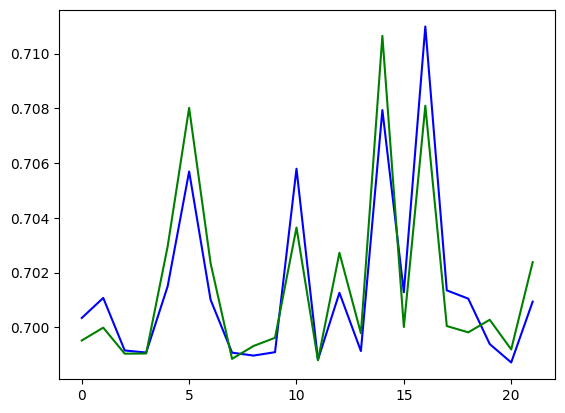

In [73]:
plt.plot(batch_train_loss[1],c='b')
plt.plot(batch_test_loss[1],c='g')
plt.show()

In [74]:
# Accuracy on test data
CNN_model.test(x_test,y_test)

0.49333333333333335

## Temp